Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
SNR de sofia.mp3: 22.17 dB
SNR de geral.mp3: 31.18 dB


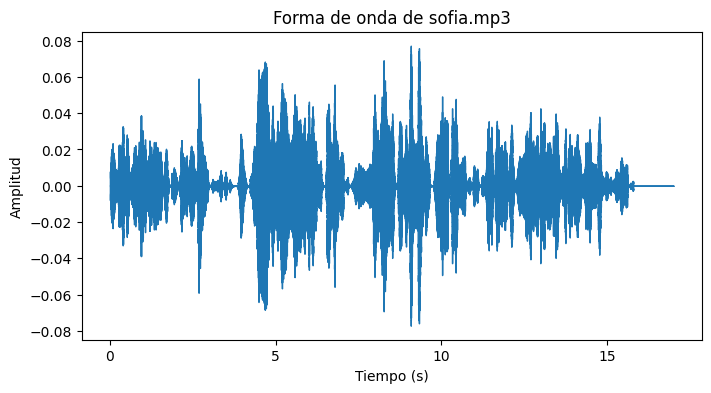

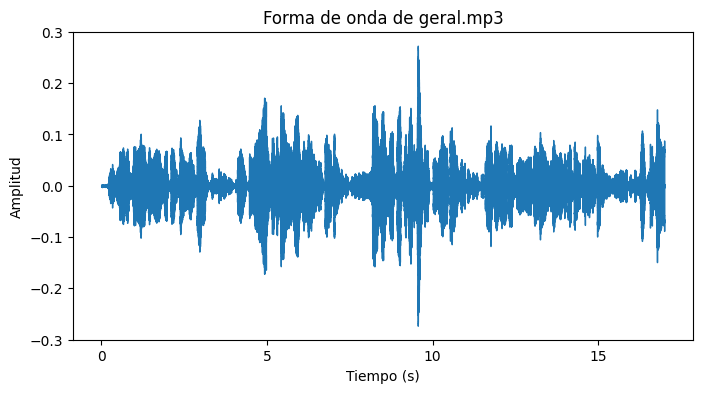

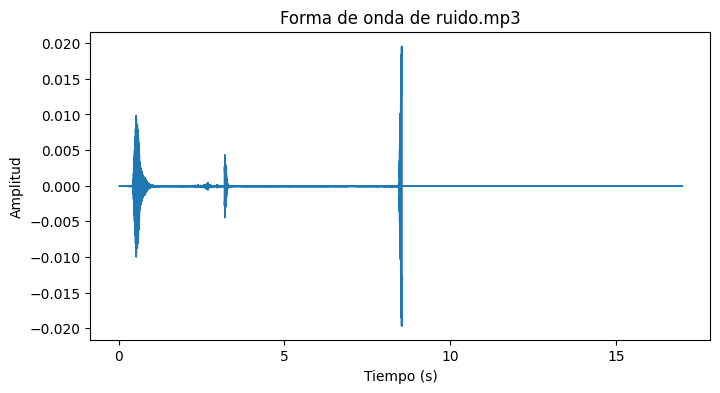

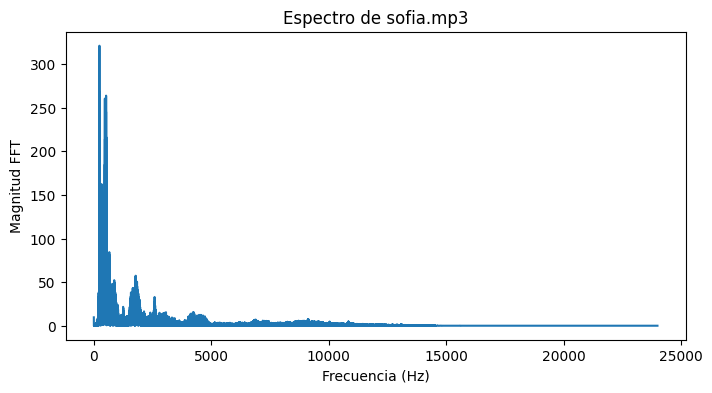

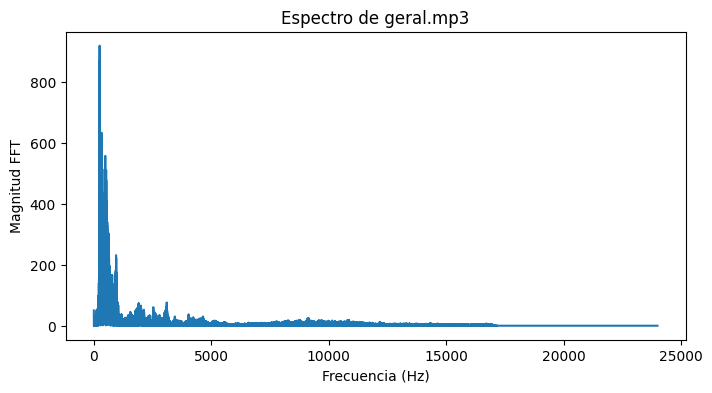

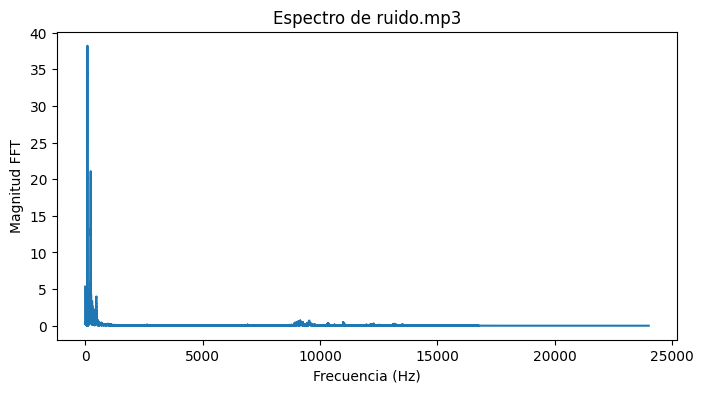

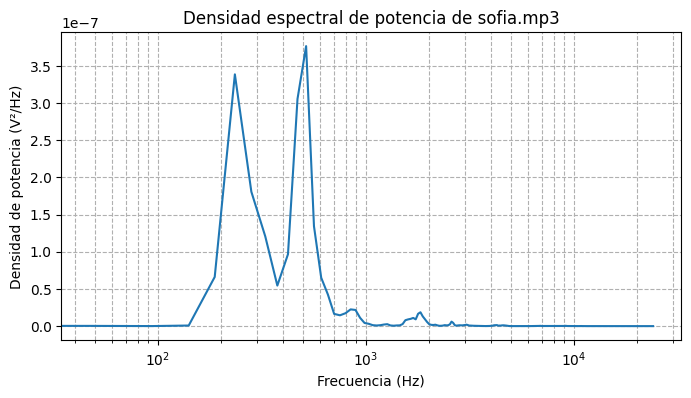

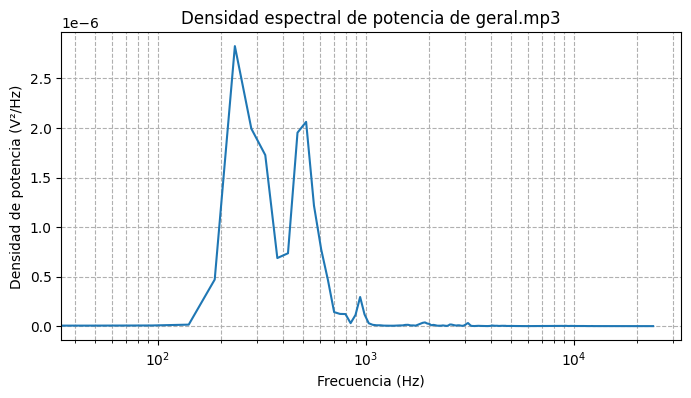

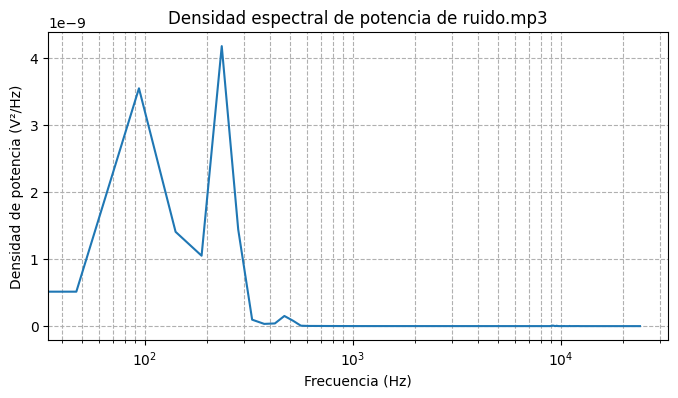

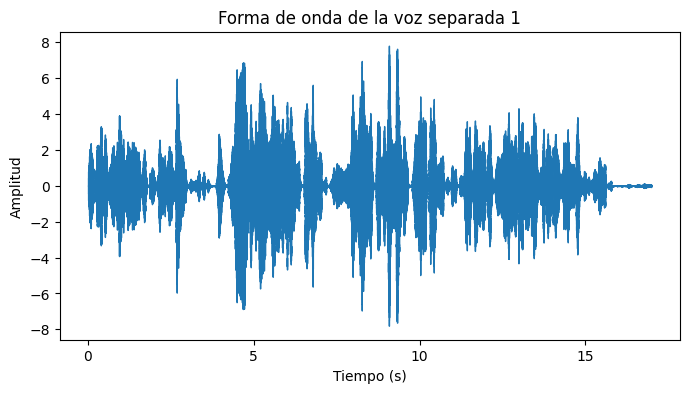

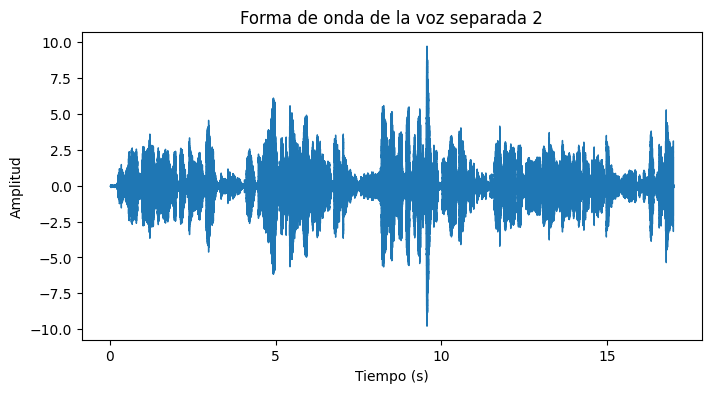

Se guardó la voz separada 1 en: /content/drive/My Drive/lab3/voz_separada_1.mp3
Se guardó la voz separada 2 en: /content/drive/My Drive/lab3/voz_separada_2.mp3


In [4]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.fftpack import fft
from scipy.signal import welch, correlate
from sklearn.decomposition import FastICA
import os

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Ruta de la carpeta en Google Drive
base_path = "/content/drive/My Drive/lab3"

# Nombres de archivos en la carpeta "lab3"
files = ["sofia.mp3", "geral.mp3", "ruido.mp3"]
file_paths = [os.path.join(base_path, f) for f in files]

# Función para calcular SNR
def calculate_snr(signal, noise):
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    return 10 * np.log10(signal_power / noise_power)

# Cargar señales desde los archivos
signals = []
sr = None

for file in file_paths:
    signal, sr = librosa.load(file, sr=None)
    signals.append(signal)

# Ajustar longitud de señales al máximo encontrado
max_length = max(len(sig) for sig in signals)
signals = np.array([np.pad(sig, (0, max_length - len(sig))) for sig in signals])

# Última señal es el ruido
ruido = signals[-1]

# Calcular SNR para cada señal
snr_values = {}
for i in range(len(signals) - 1):  # Excluyendo el ruido
    snr_values[files[i]] = calculate_snr(signals[i], ruido)
    print(f"SNR de {files[i]}: {snr_values[files[i]]:.2f} dB")

# Graficar formas de onda
for i, signal in enumerate(signals):
    plt.figure(figsize=(8, 4))
    librosa.display.waveshow(signal, sr=sr)
    plt.title(f"Forma de onda de {files[i]}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.show()

# Graficar espectro de frecuencia con FFT
for i, signal in enumerate(signals):
    N = len(signal)
    T = 1.0 / sr
    freqs = np.fft.fftfreq(N, T)[:N//2]
    fft_vals = np.abs(fft(signal))[:N//2]

    plt.figure(figsize=(8, 4))
    plt.plot(freqs, fft_vals)
    plt.title(f"Espectro de {files[i]}")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Magnitud FFT")
    plt.show()

# Graficar densidad espectral de potencia (PSD)
for i, signal in enumerate(signals):
    freqs, psd = welch(signal, fs=sr, nperseg=1024)

    plt.figure(figsize=(8, 4))
    plt.semilogx(freqs, psd)
    plt.title(f"Densidad espectral de potencia de {files[i]}")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Densidad de potencia (V²/Hz)")
    plt.grid(True, which="both", linestyle="--")
    plt.show()

# Aplicar FastICA para separar fuentes
ica = FastICA(n_components=len(signals)-1, max_iter=500)  # Excluimos el ruido
separated_sources = ica.fit_transform(signals[:-1].T).T  # Excluimos la fila de ruido

# Graficar las señales separadas
for i, source in enumerate(separated_sources):
    plt.figure(figsize=(8, 4))
    librosa.display.waveshow(source, sr=sr)
    plt.title(f"Forma de onda de la voz separada {i+1}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.show()

# Guardar cada fuente separada como archivo de audio
for i, source in enumerate(separated_sources):
    output_file = os.path.join(base_path, f"voz_separada_{i+1}.mp3")
    sf.write(output_file, source, sr)
    print(f"Se guardó la voz separada {i+1} en: {output_file}")
